# Intelligent Systems for Bioinformatics Curricular Unit
## Group 3:
- Christian Neitzel
- Diana Silva
- Ian Alves
- Samuel Baptista

# **Section 1:** Initial data exploration and preprocessing

## Drug Synergy Prediction Task Overview:
**Definition:** Synergy is a dimensionless measure of deviation of an observed drug combination response from the expected effect of non-interaction. Synergy can be calculated using different models such as the Bliss model, Highest Single Agent (HSA), Loewe additivity model and Zero Interaction Potency (ZIP). Another relevant metric is CSS which measures the drug combination sensitivity and is derived using relative IC50 values of compounds and the area under their dose- response curves.

**Impact:** Drug combination therapy offers enormous potential for expanding the use of existing drugs and in improving their efficacy. For instance, the simultaneous modulation of multiple targets can address the common mechanisms of drug resistance in the treatment of cancers. However, experimentally exploring the entire space of possible drug combinations is not a feasible task. Computational models that can predict the therapeutic potential of drug combinations can thus be immensely valuable in guiding this exploration.

**Generalization:** It is important for model predictions to be able to adapt to varying underlying biology as captured through different cell lines drawn from multiple tissues of origin. Dosage is also an important factor that can impact model generalizability.

**Product:** Small-molecule.

**Pipeline:** Activity.

## Dataset: **OncoPolyPharmacology**

**Dataset Description:** A large-scale oncology screen produced by Merck & Co., where each sample consists of two compounds and a cell line. The dataset covers 583 distinct combinations, each tested against 39 human cancer cell lines derived from 7 different tissue types (lung, breast, ovarian, colon, melanoma, prostate, and other/unspecified types), ensuring a wide representation of cancer biology and enabling generalization of drug synergy predictions across multiple cancer types.

**Drug Pairs and Targets:** Pairwise combinations were constructed from 38 diverse anticancer drugs (14 experimental and 24 approved), targeting pathways such as DNA damage repair, cell cycle regulation, and kinase signaling. Examples of novel synergistic combinations include the Wee1 inhibitor (AZD1775) and the mTOR inhibitor (ridaforolimus), which showed potent activity in ovarian cancer models.

**Synergy Scoring:** Synergy quantifies the deviation from non-interaction, with positive scores indicating synergistic effects and negative scores indicating antagonistic interactions. Most combinations exhibit additive or no effects, with true synergy being rare. The synergy score is calculated by Loewe Additivity values using the batch processing mode of Combenefit.

**Experimental Design:** Drug combinations were tested using a 4x4 dose-response matrix, capturing the interactions between drugs at varying concentrations. Cell viability was measured relative to untreated controls, and synergy scores were calculated using the Loewe Additivity Model, which assumes that if two drugs act without interaction, their combined effect should match the sum of their individual effects. Deviations from this additive effect indicate synergy (positive scores) or antagonism (negative scores). Some combinations were tested exhaustively in pairwise fashion, while others followed a supplemental strategy where specific drugs were tested selectively. Synergy and antagonism were found to be relatively rare phenomena. Known synergistic pairs, like the PARP inhibitor and temozolomide, were validated, and promising combinations, like Wee1 and mTOR inhibitors, were tested in xenograft models, demonstrating significant tumor growth inhibition and prolonged survival compared to monotherapy.

**Gene Expression Features:** Genomic data for cell lines was derived from untreated cell lines. The genomic features are from ArrayExpress database (accession number: E-MTAB-3610). Features were quantile normalized and summarized with Factor Analysis for Robust Microarray Summarization (FARMS) algorithm, resulting in 3,984 robust genomic descriptors.

**Dataset Utility:**
This dataset is a multimodal resource, integrating chemical descriptors (SMILES strings) and genomic data for cell lines to predict drug synergy. It addresses the experimental infeasibility of testing all potential drug combinations and offers computational researchers a valuable tool to guide drug discovery. By providing insights into context-specific drug interactions, it has the potential to improve precision medicine approaches in oncology.

**Task Description:** Regression. Given the gene expression of cell lines and two SMILES strings of the drug combos, predict the drug synergy level.

**Dataset Statistics:** 23,052 drug combo-cell line points, among 39 cancer cell lines and 37 drugs

**Note:** The processed data is provided by DeepSynergy.

## References and links:

[https://tdcommons.ai/multi_pred_tasks/drugsyn](https://tdcommons.ai/multi_pred_tasks/drugsyn)

[https://aacrjournals.org/mct/article/15/6/1155/92159/An-Unbiased-Oncology-Compound-Screen-to-Identify](https://aacrjournals.org/mct/article/15/6/1155/92159/An-Unbiased-Oncology-Compound-Screen-to-Identify)

[1]	J. O’Neil et al., “An Unbiased Oncology Compound Screen to Identify Novel Combination Strategies,” Molecular Cancer Therapeutics, vol. 15, no. 6, pp. 1155–1162, Jun. 2016, doi: 10.1158/1535-7163.MCT-15-0843

[https://academic.oup.com/bioinformatics/article/34/9/1538/4747884?login=false](https://academic.oup.com/bioinformatics/article/34/9/1538/4747884?login=false)

[2]	K. Preuer, R. P. I. Lewis, S. Hochreiter, A. Bender, K. C. Bulusu, and G. Klambauer, “DeepSynergy: predicting anti-cancer drug synergy with Deep Learning,” Bioinformatics, vol. 34, no. 9, pp. 1538–1546, May 2018, doi: 10.1093/bioinformatics/btx806



Imports

In [1]:
from tdc.multi_pred import DrugSyn

from typing import OrderedDict

import pandas as pd
import numpy as np

from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import Chem, RDLogger
from rdkit.Chem import Draw, Descriptors, AllChem
from rdkit.Chem.GraphDescriptors import Ipc
from rdkit.ML.Descriptors import MoleculeDescriptors

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold


# from matplotlib import pyplot as plt


## Data load and exploration

The OncoPolyPharmacology dataset contains 7 columns:

- **Drug_1_ID**: Contains the drug 1 ids
- **Drug_2_ID**: Contains the drug 2 ids
- **Cell_Line_ID**: Contains the cell line ids
- **Y**: Contains the synergy score (label)
- **Cell_Line**: Contains the genomic features for cell lines (inside a list)
- **Drug1**: Contains the drug 1 smiles representations
- **Drug2**: Contains the drug 2 smiles representations

In [4]:
data = DrugSyn(name = 'OncoPolyPharmacology')
dataset = data.get_data()
print(dataset.shape)
dataset.head()

Found local copy...
Loading...
Done!


(23052, 7)


,Drug1_ID,Drug2_ID,Cell_Line_ID,Y,Cell_Line,Drug1,Drug2
0,5-FU,ABT-888,A2058,7.693530,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
1,5-FU,ABT-888,A2780,7.778053,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
2,5-FU,ABT-888,A375,-1.198505,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
3,5-FU,ABT-888,A427,2.595684,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
4,5-FU,ABT-888,CAOV3,-5.139971,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1


In [5]:
# general information about the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23052 entries, 0 to 23051
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Drug1_ID      23052 non-null  object 
 1   Drug2_ID      23052 non-null  object 
 2   Cell_Line_ID  23052 non-null  object 
 3   Y             23052 non-null  float64
 4   Cell_Line     23052 non-null  object 
 5   Drug1         23052 non-null  object 
 6   Drug2         23052 non-null  object 
dtypes: float64(1), object(6)
memory usage: 1.2+ MB


Before advancing, we confirmed that the dataset has no missing values in any column.

In [7]:
# check missing values
dataset.isnull().sum()

Drug1_ID        0
Drug2_ID        0
Cell_Line_ID    0
Y               0
Cell_Line       0
Drug1           0
Drug2           0
dtype: int64

In [8]:
unique_drug1_id = dataset['Drug1_ID'].value_counts()
print(unique_drug1_id)

Drug1_ID
MRK-003             1449
MK-4541             1443
L778123             1005
ZOLINZA              858
SUNITINIB            795
MITOMYCINE           795
5-FU                 795
METHOTREXATE         780
DEXAMETHASONE        780
DOXORUBICIN          780
VINBLASTINE          780
CYCLOPHOSPHAMIDE     780
METFORMIN            780
CARBOPLATIN          780
PACLITAXEL           780
TEMOZOLOMIDE         771
AZD1775              747
VINORELBINE          741
ETOPOSIDE            741
GEMCITABINE          732
LAPATINIB            678
MK-5108              624
MK-4827              615
MK-2206              576
ERLOTINIB            507
PD325901             468
BORTEZOMIB           429
DASATINIB            405
ABT-888              351
MK-8669              312
GELDANAMYCIN         273
BEZ-235              195
TOPOTECAN            156
OXALIPLATIN          117
SN-38                117
SORAFENIB             78
DINACICLIB            39
Name: count, dtype: int64


In [9]:
unique_drug2_id = dataset['Drug2_ID'].value_counts()
print(unique_drug2_id)

Drug2_ID
MK-8776             1548
DINACICLIB          1404
SORAFENIB           1365
BEZ-235             1263
GELDANAMYCIN        1170
MK-8669             1161
ABT-888             1092
DASATINIB           1068
BORTEZOMIB          1014
PD325901             975
ERLOTINIB            951
MK-2206              927
MK-4827              873
MK-5108              819
LAPATINIB            795
AZD1775              771
SN-38                756
OXALIPLATIN          741
TOPOTECAN            702
TEMOZOLOMIDE         702
SUNITINIB            678
ZOLINZA              585
L778123              468
GEMCITABINE          156
ETOPOSIDE            117
VINORELBINE          117
VINBLASTINE           93
CARBOPLATIN           78
5-FU                  78
DEXAMETHASONE         78
DOXORUBICIN           78
METFORMIN             78
METHOTREXATE          78
MITOMYCINE            78
PACLITAXEL            78
CYCLOPHOSPHAMIDE      78
MRK-003               39
Name: count, dtype: int64


In [10]:
unique_drug1_id = set(dataset['Drug1_ID'].unique())
print(unique_drug1_id)
unique_drug2_id = set(dataset['Drug2_ID'].unique())
print(unique_drug2_id)

# check if unique drug1 are the same as unique drug2
if unique_drug1_id == unique_drug2_id:
    print("Unique drug1 match unique drug2")
else:
    print("Unique drug1 don't match unique drug2")

{'GEMCITABINE', 'VINBLASTINE', 'PACLITAXEL', 'L778123', 'ZOLINZA', 'LAPATINIB', 'OXALIPLATIN', '5-FU', 'BEZ-235', 'MITOMYCINE', 'CARBOPLATIN', 'SN-38', 'VINORELBINE', 'MK-2206', 'DOXORUBICIN', 'DINACICLIB', 'AZD1775', 'METFORMIN', 'DASATINIB', 'ABT-888', 'MK-4827', 'TEMOZOLOMIDE', 'SORAFENIB', 'MK-5108', 'MK-8669', 'BORTEZOMIB', 'ETOPOSIDE', 'DEXAMETHASONE', 'MRK-003', 'PD325901', 'METHOTREXATE', 'ERLOTINIB', 'TOPOTECAN', 'MK-4541', 'SUNITINIB', 'CYCLOPHOSPHAMIDE', 'GELDANAMYCIN'}
{'GEMCITABINE', 'VINBLASTINE', 'PACLITAXEL', 'L778123', 'ZOLINZA', 'LAPATINIB', 'OXALIPLATIN', '5-FU', 'BEZ-235', 'MITOMYCINE', 'CARBOPLATIN', 'SN-38', 'VINORELBINE', 'MK-2206', 'DOXORUBICIN', 'DINACICLIB', 'MK-8776', 'AZD1775', 'METFORMIN', 'DASATINIB', 'ABT-888', 'MK-4827', 'TEMOZOLOMIDE', 'SORAFENIB', 'MK-5108', 'MK-8669', 'BORTEZOMIB', 'TOPOTECAN', 'ETOPOSIDE', 'DEXAMETHASONE', 'PD325901', 'METHOTREXATE', 'ERLOTINIB', 'MRK-003', 'SUNITINIB', 'CYCLOPHOSPHAMIDE', 'GELDANAMYCIN'}
Unique drug1 don't match uni

In order to perform the machine learning pipeline *aposteriori*, we splited the dataset in train, validation and test sets with a proportion of 0.7, 0.1 and 0.2, respectively.

In [12]:
split = data.get_split(frac=[0.8, 0, 0.2])
split

{'train':       Drug1_ID   Drug2_ID  Cell_Line_ID          Y  \
 0         5-FU    ABT-888         A2058   7.693530   
 1         5-FU    ABT-888         A2780   7.778053   
 2         5-FU    ABT-888          A375  -1.198505   
 3         5-FU    ABT-888         CAOV3  -5.139971   
 4         5-FU    ABT-888     COLO320DM   4.175936   
 ...        ...        ...           ...        ...   
 18437  ZOLINZA  TOPOTECAN          T47D  18.985100   
 18438  ZOLINZA  TOPOTECAN        UACC62  10.223066   
 18439  ZOLINZA  TOPOTECAN  UWB1289BRCA1  20.551627   
 18440  ZOLINZA  TOPOTECAN       UWB1289  12.190316   
 18441  ZOLINZA  TOPOTECAN         ZR751  12.223791   
 
                                                Cell_Line  \
 0      [5.291146039856301, 5.040386719464342, 5.29114...   
 1      [5.291146039856301, 5.040386719464342, 5.29114...   
 2      [5.291146039856301, 5.040386719464342, 5.29114...   
 3      [5.291146039856301, 5.040386719464342, 5.29114...   
 4      [5.2911460398563

In [21]:
train_data = split['train']
print(train_data.shape)
train_data.head()

(18442, 7)


,Drug1_ID,Drug2_ID,Cell_Line_ID,Y,Cell_Line,Drug1,Drug2
0,5-FU,ABT-888,A2058,7.693530,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
1,5-FU,ABT-888,A2780,7.778053,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
2,5-FU,ABT-888,A375,-1.198505,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
3,5-FU,ABT-888,CAOV3,-5.139971,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
4,5-FU,ABT-888,COLO320DM,4.175936,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1


In [23]:
valid_data = split['valid']
print(valid_data.shape)
valid_data.head()

(0, 7)


,Drug1_ID,Drug2_ID,Cell_Line_ID,Y,Cell_Line,Drug1,Drug2


In [25]:
test_data = split['test']
print(test_data.shape)
test_data.head()

(4610, 7)


,Drug1_ID,Drug2_ID,Cell_Line_ID,Y,Cell_Line,Drug1,Drug2
0,CYCLOPHOSPHAMIDE,MK-4827,LNCAP,-66.134218,"[-0.18899497244411118, -0.19839747536407973, -...",O=P1(N(CCCl)CCCl)NCCCO1,NC(=O)c1cccc2cn(-c3ccc(C4CCCNC4)cc3)nc12
1,ZOLINZA,MK-4827,OCUBM,-3.809199,"[-0.18899497244411118, -0.19839747536407973, -...",O=C(CCCCCCC(=O)Nc1ccccc1)NO,NC(=O)c1cccc2cn(-c3ccc(C4CCCNC4)cc3)nc12
2,AZD1775,ERLOTINIB,KPL1,14.652960,"[-0.18899497244411118, -0.19839747536407973, -...",C=CCn1c(=O)c2cnc(Nc3ccc(N4CCN(C)CC4)cc3)nc2n1-...,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1
3,ABT-888,TOPOTECAN,EFM192B,-16.204517,"[-0.18899497244411118, -0.19839747536407973, -...",CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...
4,ABT-888,GELDANAMYCIN,ZR751,-17.080158,"[-0.18899497244411118, -0.19839747536407973, -...",CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,COC1=C2CC(C)CC(OC)C(O)C(C)C=C(C)C(OC(N)=O)C(OC...


To check if the previous sets were formed in a stratified way, we computed a summary of metrics for the label Y, both in the original dataset and the splited sets.

Firstly, we can confirm that all sets sizes are correct and secondly, that sets were formed in a stratified way, since values for each percentile are very similar, even though min and max values differ a bit.

In [28]:
print("Original dataset:")
dataset['Y'].describe()

Original dataset:


count    23052.000000
mean         5.142358
std         22.891334
min       -326.464304
25%         -5.544595
50%          4.377490
75%         15.077193
max        179.123325
Name: Y, dtype: float64

In [30]:
print("Train set:")
train_data['Y'].describe()

Train set:


count    18442.000000
mean         5.117212
std         22.902877
min       -326.464304
25%         -5.581255
50%          4.337603
75%         15.099934
max        179.123325
Name: Y, dtype: float64

In [32]:
print("Validation set:")
valid_data['Y'].describe()

Validation set:


count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Y, dtype: float64

In [34]:
print("Test set:")
test_data['Y'].describe()


Test set:


count    4610.000000
mean        5.242951
std        22.847305
min      -242.808727
25%        -5.386006
50%         4.459068
75%        15.004705
max       169.716658
Name: Y, dtype: float64

To possibly infer information related to the cell lines, we converted cell line ids to their respective tissue, and therefore to a specific type of cancer. To obtain the information about the tissue we used the [Cellosaurus](https://www.cellosaurus.org/index.html) database and performed the correspondence manually.

In [37]:
# # obtain cell line ids
# cell_line_ids = list(OrderedDict.fromkeys(dataset['Cell_Line_ID']))
# print(f"{len(cell_line_ids)} cell line ids")
# print(cell_line_ids)

In [39]:
# # corresponing tissues i.e. cancer types
# cancer_types = ['skin', 'ovarian', 'skin', 'lung', 'ovarian', 'colon', 'colon', 'breast', 'ovarian', 'colon', 'skin', 'colon', 'breast', 'prostate', 'colon', 'breast', 'lung', 'lung', 'lung', 'lung', 'lung', 'breast', 'ovarian', 'ovarian', 'ovarian', 'colon', 'skin', 'skin', 'lung', 'ovarian', 'colon', 'colon', 'breast', 'skin', 'breast', 'ovarian', 'prostate', 'breast', 'ovarian']

# # create a dictionary with cell line ids and corresponding cancer types
# cancer_dictionary = dict(zip(cell_line_ids, cancer_types))

# # add a column with the cancer types to the original dataset
# dataset['Cancer_Type'] = dataset['Cell_Line_ID'].map(cancer_dictionary)
# dataset.head()

## Data preprocessing

### Train dataset preprocessing

Create a dataset with the genomic features

In [44]:
genomic_features_train = train_data['Cell_Line']
genomic_features_train = pd.DataFrame(genomic_features_train.tolist(), columns=[f'Genomic_{i}' for i in range(len(genomic_features_train.iloc[0]))])
genomic_features_train.head()

,Genomic_0,Genomic_1,Genomic_2,Genomic_3,Genomic_4,Genomic_5,Genomic_6,Genomic_7,Genomic_8,Genomic_9,...,Genomic_8775,Genomic_8776,Genomic_8777,Genomic_8778,Genomic_8779,Genomic_8780,Genomic_8781,Genomic_8782,Genomic_8783,Genomic_8784
0,5.291146,5.040387,5.291146,0.908336,2.514969,5.291146,5.291146,-1.492008,1.143195,-0.891875,...,0.933708,0.433194,-0.705877,-0.797751,0.494978,-0.239587,1.279730,0.691891,-0.982503,-0.364565
1,5.291146,5.040387,5.291146,0.908336,2.514969,5.291146,5.291146,-1.492008,1.143195,-0.891875,...,0.453011,0.868781,-0.548668,1.191511,0.947887,0.393898,1.241226,1.139293,-1.070203,-0.425415
2,5.291146,5.040387,5.291146,0.908336,2.514969,5.291146,5.291146,-1.492008,1.143195,-0.891875,...,-0.367088,-0.495932,-0.639091,-0.346006,-0.034777,-1.268040,-0.277364,-0.423137,-1.065120,-1.002490
3,5.291146,5.040387,5.291146,0.908336,2.514969,5.291146,5.291146,-1.492008,1.143195,-0.891875,...,-1.854093,-2.383995,0.068724,-0.583244,-2.238896,-1.288220,-1.650908,-1.705543,-0.714340,0.635244
4,5.291146,5.040387,5.291146,0.908336,2.514969,5.291146,5.291146,-1.492008,1.143195,-0.891875,...,-0.743370,0.473938,2.018371,-0.209250,0.806733,-0.925696,0.576138,-0.351325,-1.015896,-0.866192


In [45]:
# shape of the genomic features dataframe
print(genomic_features_train.shape)
# remove rows with nan values
genomic_features_train = genomic_features_train.dropna()

# as we can see, the shapes are the same so there were no nan values
genomic_features_train.shape

(18442, 8785)


(18442, 8785)

In [46]:
# check if there are columns with nan values in the genomic features dataframe
genomic_features_train.isna().any().sum()

0

Standardize the data

In [48]:
RDLogger.DisableLog('rdApp.*') # disable rdkit warnings


def standardize(smiles):
    # convert to mol object
    mol = Chem.MolFromSmiles(smiles)
    
    # avoid errors with invalid molecules
    if mol is None:
        return None
     
    # removeHs, disconnect metal atoms, normalize the molecule, reionize the molecule
    clean_mol = rdMolStandardize.Cleanup(mol) 
     
    # if many fragments, get the "parent" (the actual mol we are interested in) 
    parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)
         
    # try to neutralize molecule
    uncharger = rdMolStandardize.Uncharger()
    uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)
    
    # convert back to smiles
    uncharged_parent_clean_smiles = Chem.MolToSmiles(uncharged_parent_clean_mol)
    return uncharged_parent_clean_smiles

In [49]:
# apply the function to the "Drug1" SMILES column
standardized_drug1_train = train_data.copy().apply(lambda x: standardize(x['Drug1']), axis=1)
standardized_drug1_train.head()

0    O=c1[nH]cc(F)c(=O)[nH]1
1    O=c1[nH]cc(F)c(=O)[nH]1
2    O=c1[nH]cc(F)c(=O)[nH]1
3    O=c1[nH]cc(F)c(=O)[nH]1
4    O=c1[nH]cc(F)c(=O)[nH]1
dtype: object

In [50]:
# apply the function to the "Drug2" SMILES column
standardized_drug2_train = train_data.copy().apply(lambda x: standardize(x['Drug2']), axis=1)
standardized_drug2_train.head()

0    CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
1    CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
2    CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
3    CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
4    CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
dtype: object

In [51]:
unique_drug1_train = list(train_data['Drug1'].unique())
unique_drug1_id_train = list(train_data['Drug1_ID'].unique())
unique_standardized_drug1_train = list(standardized_drug1_train.unique())

unique_drug2_train = list(train_data['Drug2'].unique())
unique_drug2_id_train = list(train_data['Drug2_ID'].unique())
unique_standardized_drug2_train = list(standardized_drug2_train.unique())

Unique Drug1 molecules


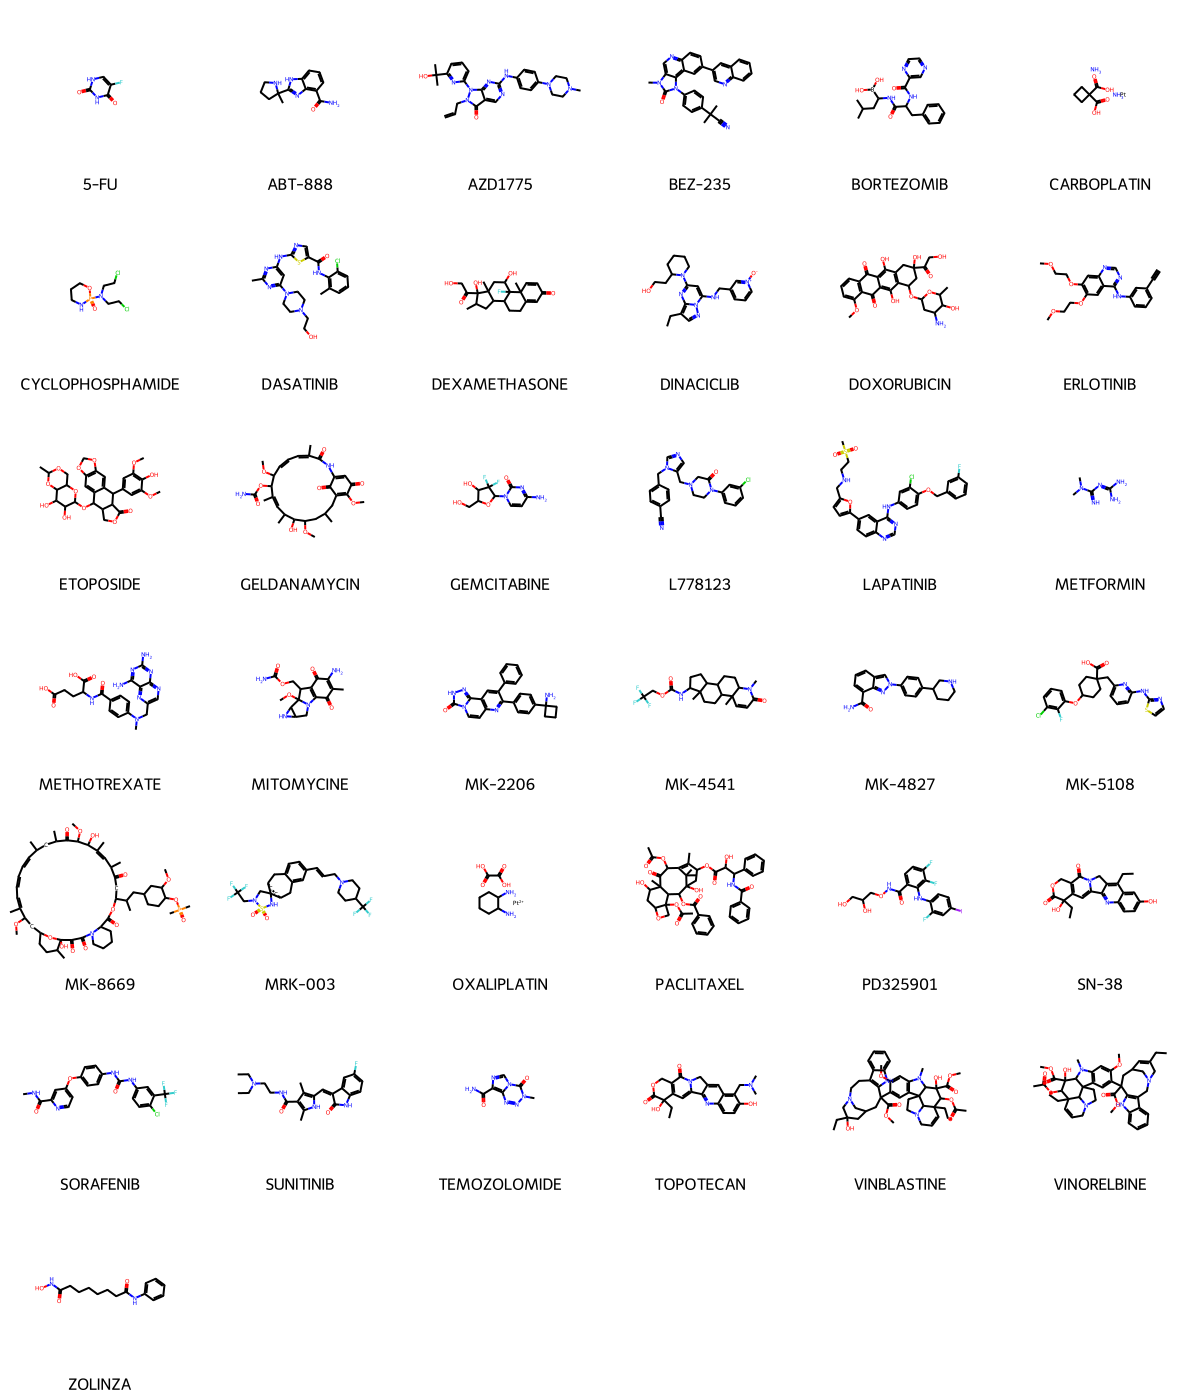

In [52]:
print("Unique Drug1 molecules")
Draw.MolsToGridImage(mols=[Chem.MolFromSmiles(drug) for drug in unique_drug1_train], molsPerRow=6, legends=unique_drug1_id_train)

Unique Drug1 standardized molecules


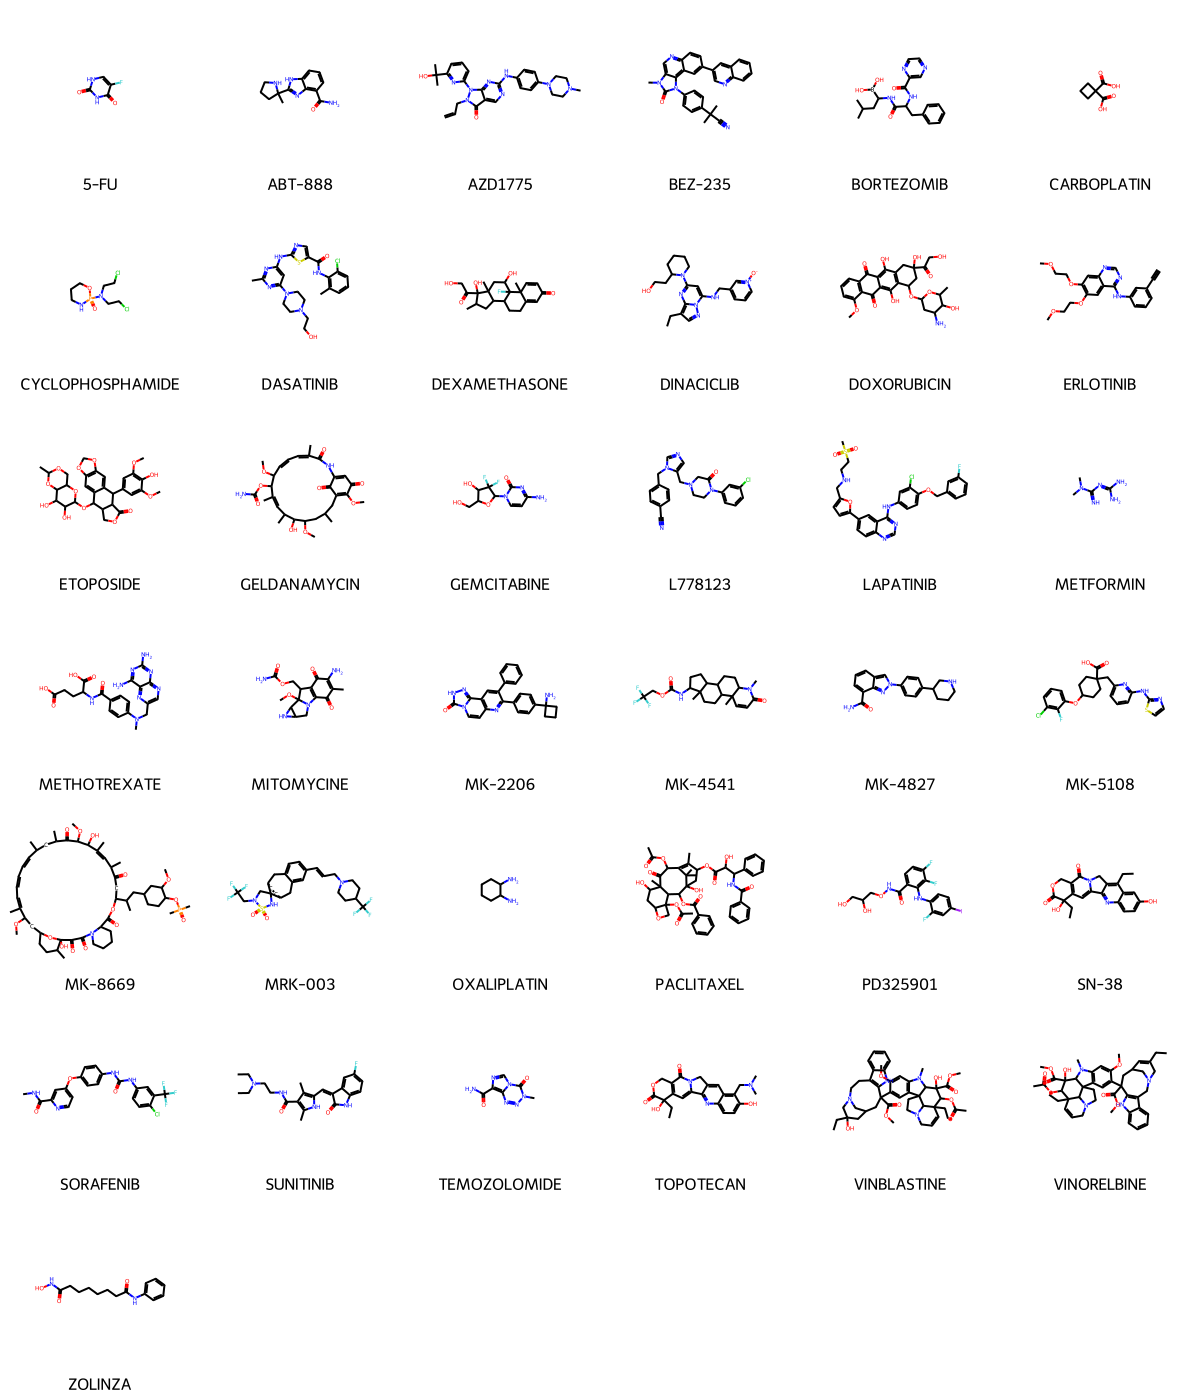

In [53]:
print("Unique Drug1 standardized molecules")
Draw.MolsToGridImage(mols=[Chem.MolFromSmiles(smiles) for smiles in unique_standardized_drug1_train], molsPerRow=6, legends=unique_drug1_id_train)

Unique Drug2 molecules


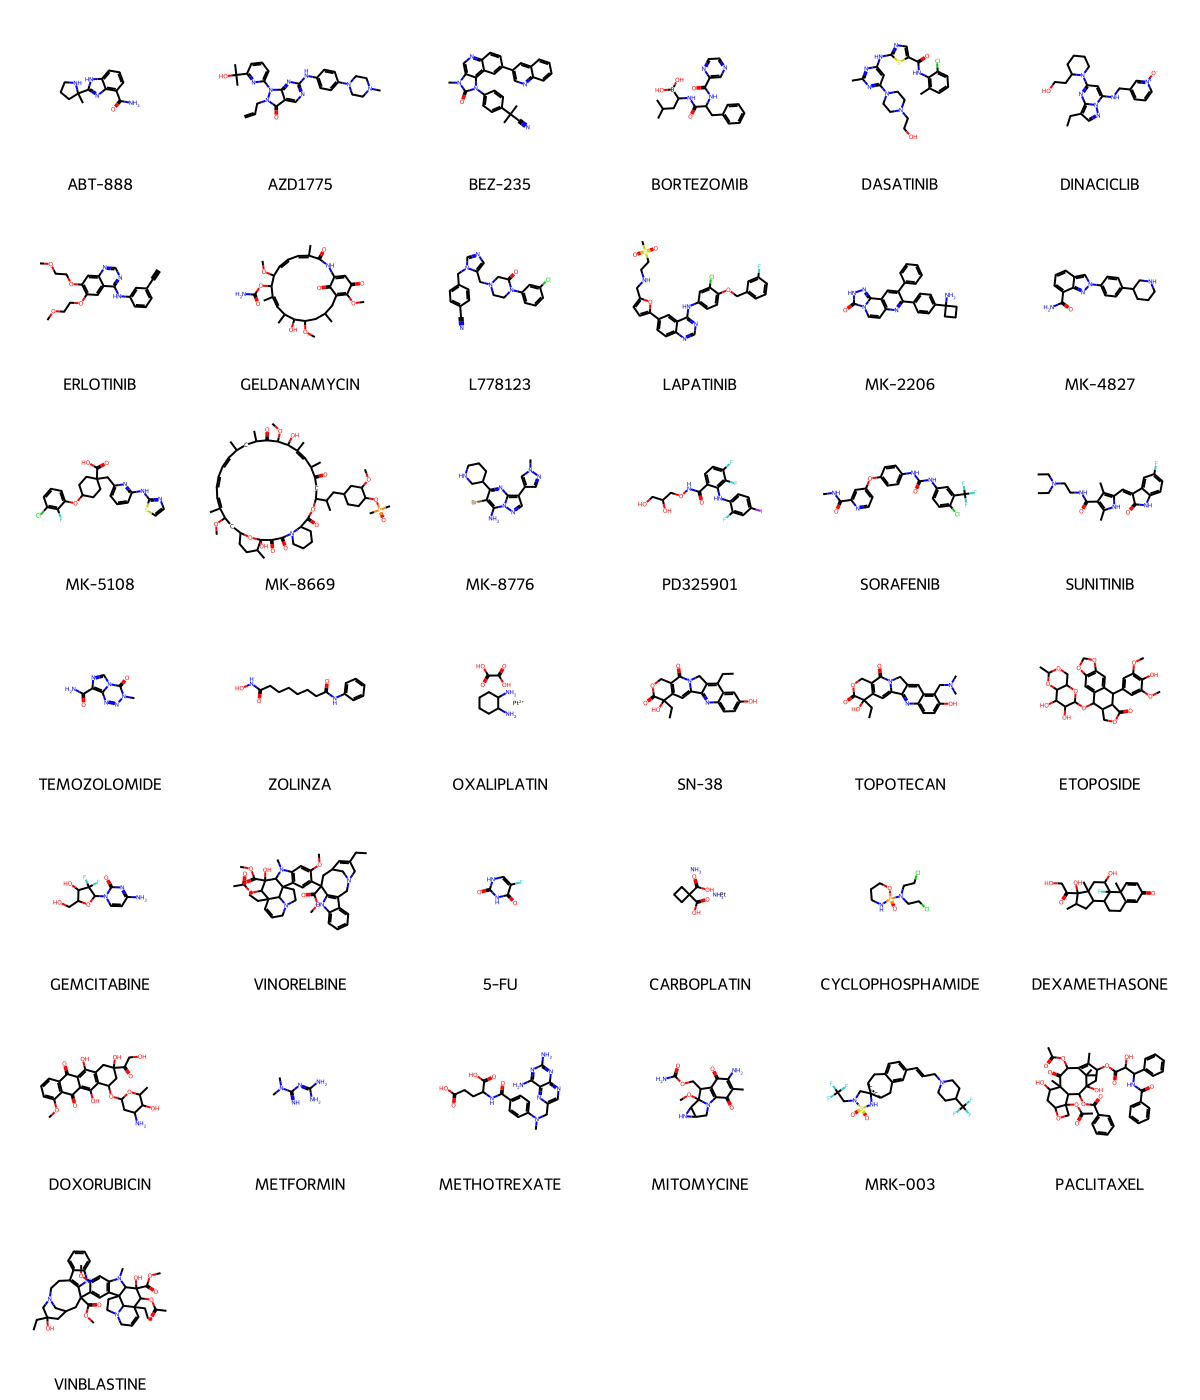

In [54]:
print("Unique Drug2 molecules")
Draw.MolsToGridImage(mols=[Chem.MolFromSmiles(drug) for drug in unique_drug2_train], molsPerRow=6, legends=unique_drug2_id_train)

Unique Drug2 standardized molecules


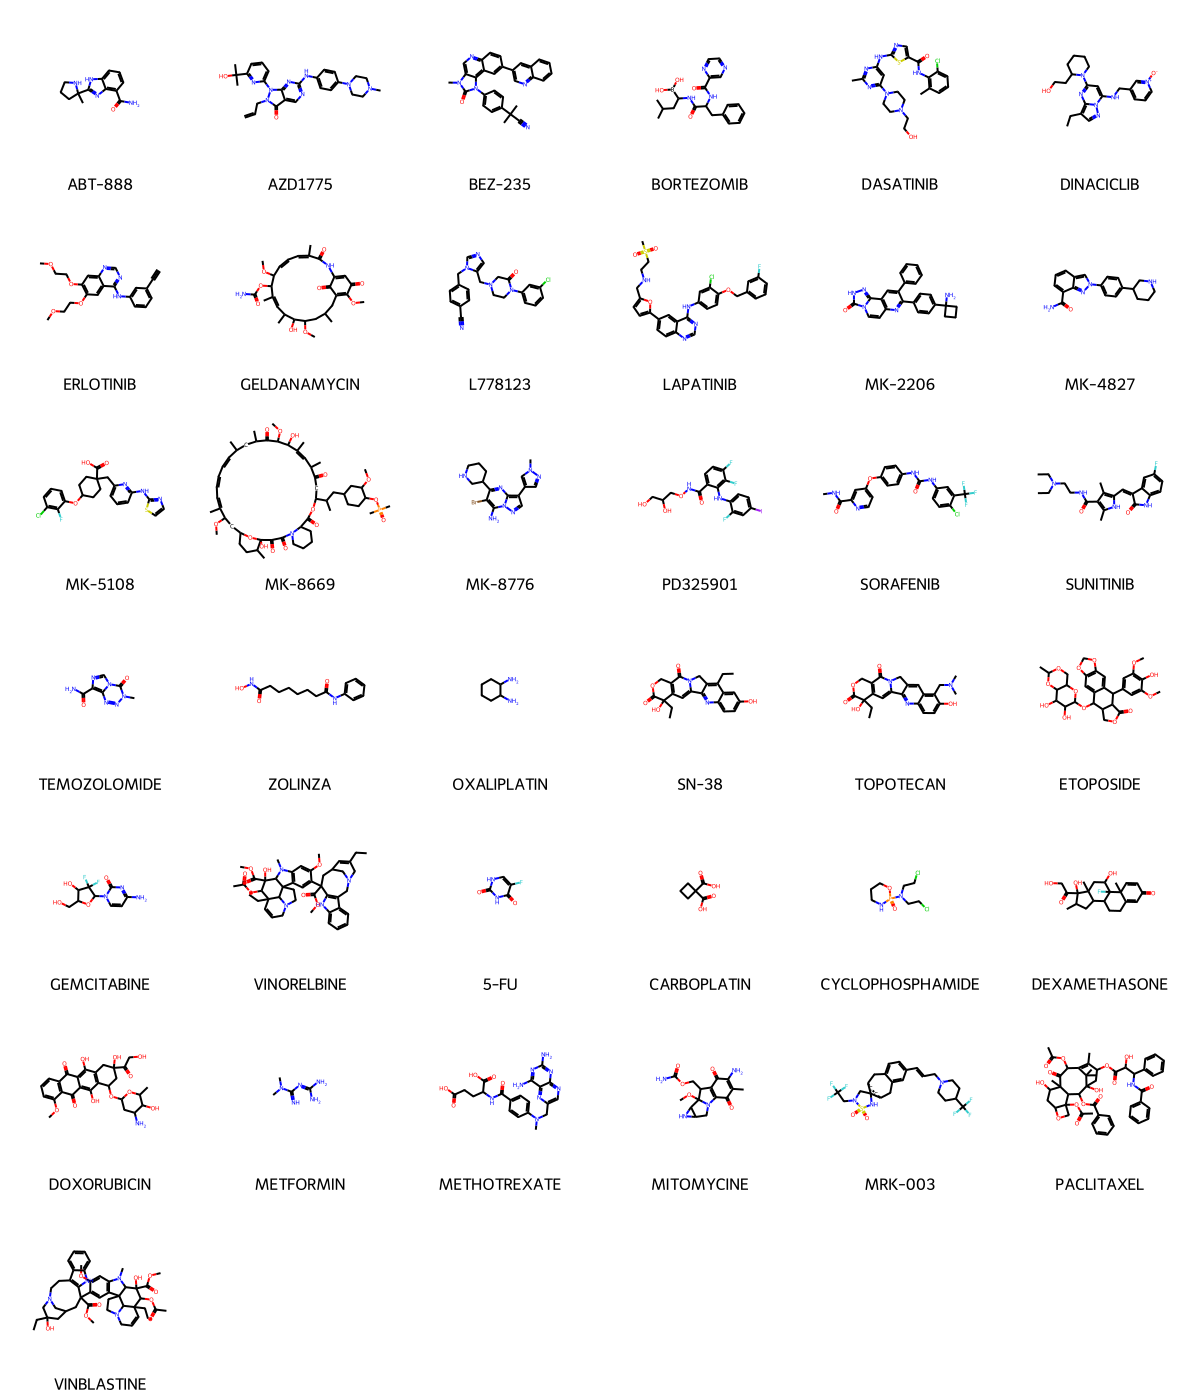

In [55]:
print("Unique Drug2 standardized molecules")
Draw.MolsToGridImage(mols=[Chem.MolFromSmiles(smiles) for smiles in unique_standardized_drug2_train], molsPerRow=6, legends=unique_drug2_id_train)

Create features with RDKit

Create descriptors

In [58]:
# 2D descriptors
def get_descriptors(smiles):
    feature_names = [x[0] for x in Descriptors._descList]
    try:
        mol = Chem.MolFromSmiles(smiles)
        calc = MoleculeDescriptors.MolecularDescriptorCalculator(feature_names)
        # Deal with very large/inf values of the Ipc descriptor (https://github.com/rdkit/rdkit/issues/1527)
        # find position of Ipc
        pos = feature_names.index("Ipc")
        # calculate AvgIpc
        avg_ipc = Ipc(mol, avg=1)

        descriptors = list(calc.CalcDescriptors(mol))
        # replace Ipc with AvgIpc
        descriptors[pos] = avg_ipc
        descriptors = np.array(descriptors, dtype=np.float32)
        return descriptors
    except:
        # return np array of nans of size feature_names
        return np.empty(len(feature_names)) * np.nan

In [59]:
# calculate descriptors for drug1
descriptors_drug1_train = standardized_drug1_train.apply(lambda x: get_descriptors(x))
# convert to dataframe
descriptors_drug1_train = pd.DataFrame(descriptors_drug1_train.values.tolist(), columns=[f'{x[0]}_drug1' for x in Descriptors._descList])
descriptors_drug1_train.head()

,MaxAbsEStateIndex_drug1,MaxEStateIndex_drug1,MinAbsEStateIndex_drug1,MinEStateIndex_drug1,qed_drug1,SPS_drug1,MolWt_drug1,HeavyAtomMolWt_drug1,ExactMolWt_drug1,NumValenceElectrons_drug1,...,fr_sulfide_drug1,fr_sulfonamd_drug1,fr_sulfone_drug1,fr_term_acetylene_drug1,fr_tetrazole_drug1,fr_thiazole_drug1,fr_thiocyan_drug1,fr_thiophene_drug1,fr_unbrch_alkane_drug1,fr_urea_drug1
0,11.984815,11.984815,0.707037,-1.001157,0.482565,9.444445,130.078003,127.054001,130.017853,48.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11.984815,11.984815,0.707037,-1.001157,0.482565,9.444445,130.078003,127.054001,130.017853,48.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11.984815,11.984815,0.707037,-1.001157,0.482565,9.444445,130.078003,127.054001,130.017853,48.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11.984815,11.984815,0.707037,-1.001157,0.482565,9.444445,130.078003,127.054001,130.017853,48.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11.984815,11.984815,0.707037,-1.001157,0.482565,9.444445,130.078003,127.054001,130.017853,48.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
# calculate descriptors for drug2
descriptors_drug2_train = standardized_drug2_train.apply(lambda x: get_descriptors(x))
# convert to dataframe
descriptors_drug2_train = pd.DataFrame(descriptors_drug2_train.values.tolist(), columns=[f'{x[0]}_drug2' for x in Descriptors._descList])
descriptors_drug2_train.head()

,MaxAbsEStateIndex_drug2,MaxEStateIndex_drug2,MinAbsEStateIndex_drug2,MinEStateIndex_drug2,qed_drug2,SPS_drug2,MolWt_drug2,HeavyAtomMolWt_drug2,ExactMolWt_drug2,NumValenceElectrons_drug2,...,fr_sulfide_drug2,fr_sulfonamd_drug2,fr_sulfone_drug2,fr_term_acetylene_drug2,fr_tetrazole_drug2,fr_thiazole_drug2,fr_thiocyan_drug2,fr_thiophene_drug2,fr_unbrch_alkane_drug2,fr_urea_drug2
0,11.377987,11.377987,0.131016,-0.441496,0.743254,23.611111,244.298004,228.169998,244.132416,94.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11.377987,11.377987,0.131016,-0.441496,0.743254,23.611111,244.298004,228.169998,244.132416,94.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11.377987,11.377987,0.131016,-0.441496,0.743254,23.611111,244.298004,228.169998,244.132416,94.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11.377987,11.377987,0.131016,-0.441496,0.743254,23.611111,244.298004,228.169998,244.132416,94.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11.377987,11.377987,0.131016,-0.441496,0.743254,23.611111,244.298004,228.169998,244.132416,94.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Create morgan fingerprints

In [62]:
# Morgan fingerprints
def get_morgan_fingerprints(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        morgan_fingerprints = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
        return np.array(morgan_fingerprints, np.float32)
    except:
        # return np array of nans of size feature_names
        return np.empty(1024) * np.nan

In [63]:
# calculate morgan fingerprints for drug 1
morgan_fingerprints_drug1_train = standardized_drug1_train.apply(lambda x: get_morgan_fingerprints(x))
# convert to dataframe
morgan_fingerprints_drug1_train = pd.DataFrame(morgan_fingerprints_drug1_train.values.tolist(), columns=[f'Morgan_{i}_drug1' for i in range(1024)])
morgan_fingerprints_drug1_train.head()

,Morgan_0_drug1,Morgan_1_drug1,Morgan_2_drug1,Morgan_3_drug1,Morgan_4_drug1,Morgan_5_drug1,Morgan_6_drug1,Morgan_7_drug1,Morgan_8_drug1,Morgan_9_drug1,...,Morgan_1014_drug1,Morgan_1015_drug1,Morgan_1016_drug1,Morgan_1017_drug1,Morgan_1018_drug1,Morgan_1019_drug1,Morgan_1020_drug1,Morgan_1021_drug1,Morgan_1022_drug1,Morgan_1023_drug1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
# calculate morgan fingerprints for drug 2
morgan_fingerprints_drug2_train = standardized_drug2_train.apply(lambda x: get_morgan_fingerprints(x))
# convert to dataframe
morgan_fingerprints_drug2_train = pd.DataFrame(morgan_fingerprints_drug2_train.values.tolist(), columns=[f'Morgan_{i}_drug2' for i in range(1024)])
morgan_fingerprints_drug2_train.head()

,Morgan_0_drug2,Morgan_1_drug2,Morgan_2_drug2,Morgan_3_drug2,Morgan_4_drug2,Morgan_5_drug2,Morgan_6_drug2,Morgan_7_drug2,Morgan_8_drug2,Morgan_9_drug2,...,Morgan_1014_drug2,Morgan_1015_drug2,Morgan_1016_drug2,Morgan_1017_drug2,Morgan_1018_drug2,Morgan_1019_drug2,Morgan_1020_drug2,Morgan_1021_drug2,Morgan_1022_drug2,Morgan_1023_drug2
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Data imputation

In [66]:
# shape of the drug1 dataframes
print(descriptors_drug1_train.shape, morgan_fingerprints_drug1_train.shape)
# remove rows where all values are nan
descriptors_drug1_train = descriptors_drug1_train.dropna(how='all')

# we do the same for morgan_fingerprints
morgan_fingerprints_drug1_train = morgan_fingerprints_drug1_train.dropna(how='all')
# as we can see, the shapes are the same, because there was no invalid molecule
descriptors_drug1_train.shape, morgan_fingerprints_drug1_train.shape

(18442, 210) (18442, 1024)


((18442, 210), (18442, 1024))

In [67]:
# check if there are columns with nan values in the drug1 dataframes
descriptors_drug1_train.isna().any().sum(), morgan_fingerprints_drug1_train.isna().any().sum()

(0, 0)

In [68]:
# shape of the drug2 dataframes
print(descriptors_drug2_train.shape, morgan_fingerprints_drug2_train.shape)
# remove rows where all values are nan
descriptors_drug2_train = descriptors_drug2_train.dropna(how='all')

# we do the same for morgan_fingerprints
morgan_fingerprints_drug2_train = morgan_fingerprints_drug2_train.dropna(how='all')
# as we can see, the shapes are the same, because there was no invalid molecule
descriptors_drug2_train.shape, morgan_fingerprints_drug2_train.shape

(18442, 210) (18442, 1024)


((18442, 210), (18442, 1024))

In [69]:
# check if there are columns with nan values in the drug2 dataframes
descriptors_drug2_train.isna().any().sum(), morgan_fingerprints_drug2_train.isna().any().sum()

(0, 0)

Data scalling

In [71]:
# scale features data with StandardScaler
scaler = StandardScaler()

In [72]:
# scale drug1 descriptors data
scaled_descriptors_drug1_train = scaler.fit_transform(descriptors_drug1_train)
scaled_descriptors_drug1_train

array([[-0.35563913, -0.35563913,  3.6571505 , ...,  0.        ,
        -0.1984838 , -0.05665234],
       [-0.35563913, -0.35563913,  3.6571505 , ...,  0.        ,
        -0.1984838 , -0.05665234],
       [-0.35563913, -0.35563913,  3.6571505 , ...,  0.        ,
        -0.1984838 , -0.05665234],
       ...,
       [-0.5455508 , -0.5455508 , -0.7548232 , ...,  0.        ,
         5.0381947 , -0.05665234],
       [-0.5455508 , -0.5455508 , -0.7548232 , ...,  0.        ,
         5.0381947 , -0.05665234],
       [-0.5455508 , -0.5455508 , -0.7548232 , ...,  0.        ,
         5.0381947 , -0.05665234]], dtype=float32)

In [73]:
# scale drug2 descriptors data
scaled_descriptors_drug2_train = scaler.fit_transform(descriptors_drug2_train)
scaled_descriptors_drug2_train

array([[-0.20108297, -0.20108297, -0.22561991, ...,  0.        ,
        -0.16469173, -0.24744058],
       [-0.20108297, -0.20108297, -0.22561991, ...,  0.        ,
        -0.16469173, -0.24744058],
       [-0.20108297, -0.20108297, -0.22561991, ...,  0.        ,
        -0.16469173, -0.24744058],
       ...,
       [ 0.51049465,  0.51049465, -0.4417698 , ...,  0.        ,
        -0.16469173, -0.24744058],
       [ 0.51049465,  0.51049465, -0.4417698 , ...,  0.        ,
        -0.16469173, -0.24744058],
       [ 0.51049465,  0.51049465, -0.4417698 , ...,  0.        ,
        -0.16469173, -0.24744058]], dtype=float32)

In [74]:
# scale genomic features data
scaled_genomic_features_train = scaler.fit_transform(genomic_features_train)
scaled_genomic_features_train

array([[ 5.2697885 ,  5.03445273,  5.2697885 , ...,  0.69255619,
        -0.98685984, -0.36491471],
       [ 5.2697885 ,  5.03445273,  5.2697885 , ...,  1.13974775,
        -1.07474745, -0.42588668],
       [ 5.2697885 ,  5.03445273,  5.2697885 , ..., -0.42194748,
        -1.06965312, -1.00411498],
       ...,
       [-0.18976094, -0.19863132, -0.18976094, ..., -0.37306053,
        -0.0759807 , -0.21791304],
       [-0.18976094, -0.19863132, -0.18976094, ..., -0.37306053,
        -0.0759807 , -0.21791304],
       [-0.18976094, -0.19863132, -0.18976094, ..., -1.70374904,
        -0.71813347,  0.63691429]])

Feature selection

In [76]:
# select drug1 and drug2 descriptors with variance > 0.01
selector = VarianceThreshold(threshold=0.01)

In [77]:
# select drug1 descriptors

# initial descriptors shape
print(f'{descriptors_drug1_train.shape[1]} initial descriptors')

# selected drug1 descriptors
selected_descriptors_drug1_train = selector.fit_transform(scaled_descriptors_drug1_train)
selected_columns = descriptors_drug1_train.columns[selector.get_support()]
print(selected_descriptors_drug1_train.shape, selected_columns)

# number of drug1 descriptors removed
print(f'{descriptors_drug1_train.shape[1] - selected_descriptors_drug1_train.shape[1]} drug1 descriptors removed')

# convert selected drug1 descriptors numpy array into a pandas dataframe
selected_descriptors_drug1_train = pd.DataFrame(selected_descriptors_drug1_train, columns=selected_columns) 
selected_descriptors_drug1_train.head()

210 initial descriptors
(18442, 173) Index(['MaxAbsEStateIndex_drug1', 'MaxEStateIndex_drug1',
       'MinAbsEStateIndex_drug1', 'MinEStateIndex_drug1', 'qed_drug1',
       'SPS_drug1', 'MolWt_drug1', 'HeavyAtomMolWt_drug1', 'ExactMolWt_drug1',
       'NumValenceElectrons_drug1',
       ...
       'fr_phenol_noOrthoHbond_drug1', 'fr_piperdine_drug1',
       'fr_piperzine_drug1', 'fr_priamide_drug1', 'fr_pyridine_drug1',
       'fr_sulfone_drug1', 'fr_term_acetylene_drug1', 'fr_thiazole_drug1',
       'fr_unbrch_alkane_drug1', 'fr_urea_drug1'],
      dtype='object', length=173)
37 drug1 descriptors removed


,MaxAbsEStateIndex_drug1,MaxEStateIndex_drug1,MinAbsEStateIndex_drug1,MinEStateIndex_drug1,qed_drug1,SPS_drug1,MolWt_drug1,HeavyAtomMolWt_drug1,ExactMolWt_drug1,NumValenceElectrons_drug1,...,fr_phenol_noOrthoHbond_drug1,fr_piperdine_drug1,fr_piperzine_drug1,fr_priamide_drug1,fr_pyridine_drug1,fr_sulfone_drug1,fr_term_acetylene_drug1,fr_thiazole_drug1,fr_unbrch_alkane_drug1,fr_urea_drug1
0,-0.355639,-0.355639,3.657151,0.512589,0.138877,-1.185201,-1.553903,-1.543471,-1.553337,-1.52273,...,-0.274424,-0.399934,-0.38317,-0.372298,-0.33165,-0.17467,-0.146405,-0.214334,-0.198484,-0.056652
1,-0.355639,-0.355639,3.657151,0.512589,0.138877,-1.185201,-1.553903,-1.543471,-1.553337,-1.52273,...,-0.274424,-0.399934,-0.38317,-0.372298,-0.33165,-0.17467,-0.146405,-0.214334,-0.198484,-0.056652
2,-0.355639,-0.355639,3.657151,0.512589,0.138877,-1.185201,-1.553903,-1.543471,-1.553337,-1.52273,...,-0.274424,-0.399934,-0.38317,-0.372298,-0.33165,-0.17467,-0.146405,-0.214334,-0.198484,-0.056652
3,-0.355639,-0.355639,3.657151,0.512589,0.138877,-1.185201,-1.553903,-1.543471,-1.553337,-1.52273,...,-0.274424,-0.399934,-0.38317,-0.372298,-0.33165,-0.17467,-0.146405,-0.214334,-0.198484,-0.056652
4,-0.355639,-0.355639,3.657151,0.512589,0.138877,-1.185201,-1.553903,-1.543471,-1.553337,-1.52273,...,-0.274424,-0.399934,-0.38317,-0.372298,-0.33165,-0.17467,-0.146405,-0.214334,-0.198484,-0.056652


In [78]:
# select drug2 descriptors

# initial descriptors shape
print(f'{descriptors_drug1_train.shape[1]} initial descriptors')

# selected drug2 descriptors
selected_descriptors_drug2_train = selector.fit_transform(scaled_descriptors_drug2_train)
selected_columns = descriptors_drug2_train.columns[selector.get_support()]
print(selected_descriptors_drug2_train.shape, selected_columns)

# number of drug2 descriptors removed
print(f'{descriptors_drug2_train.shape[1] - selected_descriptors_drug2_train.shape[1]} drug2 descriptors removed')

# convert selected drug2 descriptors numpy array into a pandas dataframe
selected_descriptors_drug2_train = pd.DataFrame(selected_descriptors_drug2_train, columns=selected_columns) 
selected_descriptors_drug2_train.head()


210 initial descriptors
(18442, 172) Index(['MaxAbsEStateIndex_drug2', 'MaxEStateIndex_drug2',
       'MinAbsEStateIndex_drug2', 'MinEStateIndex_drug2', 'qed_drug2',
       'SPS_drug2', 'MolWt_drug2', 'HeavyAtomMolWt_drug2', 'ExactMolWt_drug2',
       'NumValenceElectrons_drug2',
       ...
       'fr_phenol_noOrthoHbond_drug2', 'fr_piperdine_drug2',
       'fr_piperzine_drug2', 'fr_priamide_drug2', 'fr_pyridine_drug2',
       'fr_sulfone_drug2', 'fr_term_acetylene_drug2', 'fr_thiazole_drug2',
       'fr_unbrch_alkane_drug2', 'fr_urea_drug2'],
      dtype='object', length=172)
38 drug2 descriptors removed


,MaxAbsEStateIndex_drug2,MaxEStateIndex_drug2,MinAbsEStateIndex_drug2,MinEStateIndex_drug2,qed_drug2,SPS_drug2,MolWt_drug2,HeavyAtomMolWt_drug2,ExactMolWt_drug2,NumValenceElectrons_drug2,...,fr_phenol_noOrthoHbond_drug2,fr_piperdine_drug2,fr_piperzine_drug2,fr_priamide_drug2,fr_pyridine_drug2,fr_sulfone_drug2,fr_term_acetylene_drug2,fr_thiazole_drug2,fr_unbrch_alkane_drug2,fr_urea_drug2
0,-0.201083,-0.201083,-0.22562,0.476567,1.678674,0.602275,-1.113996,-1.150453,-1.113154,-0.991427,...,-0.270796,-0.538359,-0.336917,2.221198,-0.667298,-0.189761,-0.208597,-0.299384,-0.164692,-0.247441
1,-0.201083,-0.201083,-0.22562,0.476567,1.678674,0.602275,-1.113996,-1.150453,-1.113154,-0.991427,...,-0.270796,-0.538359,-0.336917,2.221198,-0.667298,-0.189761,-0.208597,-0.299384,-0.164692,-0.247441
2,-0.201083,-0.201083,-0.22562,0.476567,1.678674,0.602275,-1.113996,-1.150453,-1.113154,-0.991427,...,-0.270796,-0.538359,-0.336917,2.221198,-0.667298,-0.189761,-0.208597,-0.299384,-0.164692,-0.247441
3,-0.201083,-0.201083,-0.22562,0.476567,1.678674,0.602275,-1.113996,-1.150453,-1.113154,-0.991427,...,-0.270796,-0.538359,-0.336917,2.221198,-0.667298,-0.189761,-0.208597,-0.299384,-0.164692,-0.247441
4,-0.201083,-0.201083,-0.22562,0.476567,1.678674,0.602275,-1.113996,-1.150453,-1.113154,-0.991427,...,-0.270796,-0.538359,-0.336917,2.221198,-0.667298,-0.189761,-0.208597,-0.299384,-0.164692,-0.247441


In [79]:
# select drug1 and drug2 morgan fingerprints with variance > 0.01
selector = VarianceThreshold(threshold=0.01)

In [80]:
# select drug1 morgan fingerprints

# initial morgan fingerprints shape
print(f'{morgan_fingerprints_drug1_train.shape[1]} initial morgan fingarprints')

# selected drug1 morgan fingerprints
selected_morgan_fingerprints_drug1_train = selector.fit_transform(morgan_fingerprints_drug1_train)
selected_columns = morgan_fingerprints_drug1_train.columns[selector.get_support()]
print(selected_morgan_fingerprints_drug1_train.shape, selected_columns)

# number of drug1 morgan fingerprints removed
print(f'{morgan_fingerprints_drug1_train.shape[1] - selected_morgan_fingerprints_drug1_train.shape[1]} drug1 morgan fingerprints removed')

# convert selected drug1 morgan fingerprints numpy array into a pandas dataframe
selected_morgan_fingerprints_drug1_train = pd.DataFrame(selected_morgan_fingerprints_drug1_train, columns=selected_columns) 
selected_morgan_fingerprints_drug1_train.head()

1024 initial morgan fingarprints
(18442, 663) Index(['Morgan_0_drug1', 'Morgan_1_drug1', 'Morgan_3_drug1', 'Morgan_4_drug1',
       'Morgan_6_drug1', 'Morgan_7_drug1', 'Morgan_8_drug1', 'Morgan_9_drug1',
       'Morgan_11_drug1', 'Morgan_12_drug1',
       ...
       'Morgan_1008_drug1', 'Morgan_1009_drug1', 'Morgan_1010_drug1',
       'Morgan_1011_drug1', 'Morgan_1014_drug1', 'Morgan_1017_drug1',
       'Morgan_1018_drug1', 'Morgan_1019_drug1', 'Morgan_1020_drug1',
       'Morgan_1022_drug1'],
      dtype='object', length=663)
361 drug1 morgan fingerprints removed


,Morgan_0_drug1,Morgan_1_drug1,Morgan_3_drug1,Morgan_4_drug1,Morgan_6_drug1,Morgan_7_drug1,Morgan_8_drug1,Morgan_9_drug1,Morgan_11_drug1,Morgan_12_drug1,...,Morgan_1008_drug1,Morgan_1009_drug1,Morgan_1010_drug1,Morgan_1011_drug1,Morgan_1014_drug1,Morgan_1017_drug1,Morgan_1018_drug1,Morgan_1019_drug1,Morgan_1020_drug1,Morgan_1022_drug1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
# select drug2 morgan fingerprints

# initial morgan fingerprints shape
print(f'{morgan_fingerprints_drug1_train.shape[1]} initial morgan fingarprints')

# selected drug2 morgan fingerprints
selected_morgan_fingerprints_drug2_train = selector.fit_transform(morgan_fingerprints_drug2_train)
selected_columns = morgan_fingerprints_drug2_train.columns[selector.get_support()]
print(selected_morgan_fingerprints_drug2_train.shape, selected_columns)

# number of drug2 morgan fingerprints removed
print(f'{morgan_fingerprints_drug2_train.shape[1] - selected_morgan_fingerprints_drug2_train.shape[1]} drug2 morgan fingerprints removed')

# convert selected drug2 morgan fingerprints numpy array into a pandas dataframe
selected_morgan_fingerprints_drug2_train = pd.DataFrame(selected_morgan_fingerprints_drug2_train, columns=selected_columns) 
selected_morgan_fingerprints_drug2_train.head()

1024 initial morgan fingarprints
(18442, 548) Index(['Morgan_1_drug2', 'Morgan_3_drug2', 'Morgan_4_drug2', 'Morgan_6_drug2',
       'Morgan_7_drug2', 'Morgan_8_drug2', 'Morgan_9_drug2', 'Morgan_11_drug2',
       'Morgan_12_drug2', 'Morgan_13_drug2',
       ...
       'Morgan_1003_drug2', 'Morgan_1004_drug2', 'Morgan_1005_drug2',
       'Morgan_1009_drug2', 'Morgan_1010_drug2', 'Morgan_1011_drug2',
       'Morgan_1014_drug2', 'Morgan_1017_drug2', 'Morgan_1018_drug2',
       'Morgan_1019_drug2'],
      dtype='object', length=548)
476 drug2 morgan fingerprints removed


,Morgan_1_drug2,Morgan_3_drug2,Morgan_4_drug2,Morgan_6_drug2,Morgan_7_drug2,Morgan_8_drug2,Morgan_9_drug2,Morgan_11_drug2,Morgan_12_drug2,Morgan_13_drug2,...,Morgan_1003_drug2,Morgan_1004_drug2,Morgan_1005_drug2,Morgan_1009_drug2,Morgan_1010_drug2,Morgan_1011_drug2,Morgan_1014_drug2,Morgan_1017_drug2,Morgan_1018_drug2,Morgan_1019_drug2
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
# select genomic features with variance > 0.01
selector = VarianceThreshold(threshold=0.01)

# initial genomic features shape
print(f'{genomic_features_train.shape[1]} initial genomic features')

# selected genomic features
selected_genomic_features_train = selector.fit_transform(scaled_genomic_features_train)
selected_columns = genomic_features_train.columns[selector.get_support()] 
print(selected_genomic_features_train.shape, selected_columns)

# number of genomic features removed
print(f'{genomic_features_train.shape[1] - selected_genomic_features_train.shape[1]} genomic features removed')

# convert selected genomic features numpy array into a pandas dataframe
selected_genomic_features_train = pd.DataFrame(selected_genomic_features_train, columns=selected_columns) 
selected_genomic_features_train.head()

8785 initial genomic features
(18442, 8777) Index(['Genomic_0', 'Genomic_1', 'Genomic_2', 'Genomic_3', 'Genomic_4',
       'Genomic_5', 'Genomic_6', 'Genomic_7', 'Genomic_8', 'Genomic_9',
       ...
       'Genomic_8775', 'Genomic_8776', 'Genomic_8777', 'Genomic_8778',
       'Genomic_8779', 'Genomic_8780', 'Genomic_8781', 'Genomic_8782',
       'Genomic_8783', 'Genomic_8784'],
      dtype='object', length=8777)
8 genomic features removed


,Genomic_0,Genomic_1,Genomic_2,Genomic_3,Genomic_4,Genomic_5,Genomic_6,Genomic_7,Genomic_8,Genomic_9,...,Genomic_8775,Genomic_8776,Genomic_8777,Genomic_8778,Genomic_8779,Genomic_8780,Genomic_8781,Genomic_8782,Genomic_8783,Genomic_8784
0,5.269788,5.034453,5.269788,0.90597,2.510154,5.269788,5.269788,-1.493994,1.140595,-0.89096,...,0.933798,0.434777,-0.708097,-0.799171,0.493310,-0.238066,1.277929,0.692556,-0.986860,-0.364915
1,5.269788,5.034453,5.269788,0.90597,2.510154,5.269788,5.269788,-1.493994,1.140595,-0.89096,...,0.452877,0.870316,-0.551325,1.181514,0.945715,0.396515,1.239489,1.139748,-1.074747,-0.425887
2,5.269788,5.034453,5.269788,0.90597,2.510154,5.269788,5.269788,-1.493994,1.140595,-0.89096,...,-0.367603,-0.494245,-0.641496,-0.349373,-0.035854,-1.268299,-0.276589,-0.421947,-1.069653,-1.004115
3,5.269788,5.034453,5.269788,0.90597,2.510154,5.269788,5.269788,-1.493994,1.140595,-0.89096,...,-1.855299,-2.382096,0.064357,-0.585589,-2.237517,-1.288513,-1.647860,-1.703751,-0.718126,0.636893
4,5.269788,5.034453,5.269788,0.90597,2.510154,5.269788,5.269788,-1.493994,1.140595,-0.89096,...,-0.744059,0.475517,2.008599,-0.213207,0.804718,-0.925362,0.575502,-0.350169,-1.020324,-0.867545


Train dataset build

Convert selected features from numpy arrays to pandas dataframes

In [85]:
y_label_train = train_data['Y']
type(y_label_train)
train_dataset = pd.concat([selected_genomic_features_train, 
                           selected_descriptors_drug1_train,
                           selected_descriptors_drug2_train,
                           selected_morgan_fingerprints_drug1_train,
                           selected_morgan_fingerprints_drug2_train,
                           y_label_train], 
                           axis=1)
print(train_dataset.shape)
train_dataset.head()

(18442, 10334)


,Genomic_0,Genomic_1,Genomic_2,Genomic_3,Genomic_4,Genomic_5,Genomic_6,Genomic_7,Genomic_8,Genomic_9,...,Morgan_1004_drug2,Morgan_1005_drug2,Morgan_1009_drug2,Morgan_1010_drug2,Morgan_1011_drug2,Morgan_1014_drug2,Morgan_1017_drug2,Morgan_1018_drug2,Morgan_1019_drug2,Y
0,5.269788,5.034453,5.269788,0.90597,2.510154,5.269788,5.269788,-1.493994,1.140595,-0.89096,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.693530
1,5.269788,5.034453,5.269788,0.90597,2.510154,5.269788,5.269788,-1.493994,1.140595,-0.89096,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.778053
2,5.269788,5.034453,5.269788,0.90597,2.510154,5.269788,5.269788,-1.493994,1.140595,-0.89096,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.198505
3,5.269788,5.034453,5.269788,0.90597,2.510154,5.269788,5.269788,-1.493994,1.140595,-0.89096,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.139971
4,5.269788,5.034453,5.269788,0.90597,2.510154,5.269788,5.269788,-1.493994,1.140595,-0.89096,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.175936


In [86]:
train_dataset.to_csv('train_dataset')

### Feature Reduction

In [124]:
train_dataset_X = train_dataset.drop('Y', axis=1)
train_dataset_Y = train_dataset['Y']

In [126]:
from sklearn.decomposition import PCA

# Retain components that explain 99% of the variance
pca = PCA(n_components=0.99)
train_dataset_X_pca = pca.fit_transform(train_dataset_X)

# Output the shape and explained variance ratio
print(f"Reduced dataset shape: {train_dataset_X_pca.shape}")
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")

Reduced dataset shape: (18442, 99)
Explained Variance Ratio: [0.16330789 0.04803627 0.04171262 0.03159917 0.02202947 0.0217866
 0.01960041 0.01918244 0.01716012 0.01694544 0.01513471 0.01489863
 0.0137555  0.01306144 0.01250326 0.01239366 0.01203994 0.01098089
 0.0107147  0.01037081 0.01027687 0.01011754 0.01001448 0.00958564
 0.00937765 0.00931234 0.00901021 0.00877128 0.00863644 0.00859221
 0.00849851 0.00833476 0.0080056  0.00800358 0.00785681 0.00777472
 0.00769053 0.00751532 0.00745735 0.00738535 0.00730897 0.00705402
 0.00695404 0.0069153  0.00674062 0.00669833 0.00667857 0.00657389
 0.00644871 0.0063383  0.00625935 0.00619469 0.00613274 0.00602404
 0.00595137 0.00589612 0.00580499 0.00570728 0.00567261 0.00563609
 0.00557221 0.0055643  0.00542077 0.00538325 0.00518512 0.00515231
 0.00511778 0.00508088 0.00502136 0.00492605 0.00487188 0.0048305
 0.00474629 0.00473702 0.00470735 0.0046611  0.0046167  0.00452135
 0.00445744 0.00444125 0.00433949 0.00432161 0.00430281 0.00420385
 0.

In [128]:
# Create a DataFrame with the PCA-reduced dataset
pca_df = pd.DataFrame(train_dataset_X_pca)

# Add the target variable into the reduced dataset
pca_df['Y'] = train_dataset_Y

# Save to CSV
pca_df.to_csv('dataset_reduced_train.csv', index=False)

In [130]:
pca_df = pd.read_csv('dataset_reduced_train.csv')
pca_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,Y
0,-18.883184,-32.420310,-25.985315,27.170879,-8.254032,5.777924,0.982499,-2.484793,-3.561890,-8.204375,...,11.874176,-17.828926,0.265829,10.428147,2.541996,-3.065779,-10.819554,18.087840,-5.237815,7.693530
1,-17.956622,-32.262261,-26.199152,6.949495,-15.218139,6.128977,-14.024645,-4.429169,-3.667837,3.849976,...,-1.242291,1.009220,-5.395077,10.160094,2.913470,-2.006807,-4.003870,20.003795,-5.326779,7.778053
2,-14.723852,-32.524085,-26.065721,29.234158,-12.796456,5.146547,14.704915,-0.323475,-3.639054,-2.506800,...,2.515223,6.600548,-6.518480,9.717178,2.732404,-2.402559,-12.988737,18.686836,-5.099503,-1.198505
3,100.747731,-31.693001,-26.489048,1.667345,0.103404,5.948934,-2.040340,-3.032130,-3.773462,-0.205211,...,-0.463373,-1.131890,-4.617280,10.331671,2.695114,-1.851220,-3.627275,19.746133,-5.287397,-5.139971
4,-15.628133,-32.153154,-26.274322,0.103789,-21.175145,6.355946,-16.860097,-4.187028,-4.533640,13.663766,...,-2.014308,2.309309,-5.454973,10.194438,2.574322,-1.711025,-3.284007,20.146264,-5.303384,4.175936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18437,-17.293361,-19.026549,8.278668,-17.489602,-16.788205,-1.876843,6.593208,-0.090575,14.362124,-22.750645,...,0.628653,-0.924961,-8.657760,2.891559,10.875922,14.828122,-2.120276,-2.020476,-5.424513,18.985100
18438,-12.357456,-19.432330,8.884019,35.084475,-0.355219,-1.465270,6.152030,-0.306745,12.582962,-13.576869,...,-10.298194,-3.103144,-8.406653,2.072389,11.285255,14.402843,-9.216749,-2.618521,-5.406953,10.223066
18439,-15.760831,-19.060635,8.513251,-14.539525,36.628662,-0.716287,-6.899885,-2.108844,11.577311,-0.539523,...,0.600388,-3.006499,-7.897868,2.450346,11.571723,14.818538,-1.000095,-1.658199,-5.798681,20.551627
18440,-15.760831,-19.060635,8.513251,-14.539525,36.628662,-0.716287,-6.899885,-2.108844,11.577311,-0.539523,...,0.600388,-3.006499,-7.897868,2.450346,11.571723,14.818538,-1.000095,-1.658199,-5.798681,12.190316


In [ ]:
# falta acrescentar a análise exploratória antes do pré processamento
# falta repetir a pipeline anterior para o train set
# falta ver se é para excluir os outliers e acrescentar esse código

In [ ]:
# perguntar se devemos fazer o feature selection nas morgan fingerprints
# melhorar o código que transforma os arrays de features finais em dataframes